## Destination Recommender System with Implicit Feedback

Here, we build an implicit feedback recommender system using the [implicit](https://github.com/benfred/implicit) package.

The cells of the user-item matrix are populated by a given user's degree of preference towards an item, which can come in the form of:

1. **explicit feedback:** direct feedback towards an item (e.g., destination ratings which can be observed in Collaborative Filter approach.
2. **implicit feedback:** indirect behaviour towards an item (e.g., transaction history, browsing history, search behaviour)

Implicit feedback makes assumptions about a user's preference based on their actions towards items. Let's take Netflix for example. If you binge-watch a show and blaze through all seasons in a week, there's a high chance that you like that show. However, if you start watching a series and stop halfway through the first episode, there's suspicion to believe that you probably don't like that show. 


### Step 1: Import Dependencies

In [1]:
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix

import implicit

### Step 2: Load the Data

In [2]:
ratings = pd.read_csv("sample_user_ratings.csv")
destinations = pd.read_csv("sample_destinations.csv")

In [3]:
ratings.head()

,user_id,destination_id,rating
0,0,62,5
1,0,120,4
2,0,28,4
3,0,4,5
4,0,100,3


In [4]:
destinations.head()

,destination_id,title,genre,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,0,Boudhanath Stupa,['Religious Sites'],True,True,False,False,False,False,False,False,True
1,1,Phewa Tal (Fewa Lake),['Bodies of Water'],False,False,True,False,False,False,False,False,False
2,2,Sarangkot,['Mountains'],False,False,True,False,False,False,False,False,False
3,3,Swayambhunath Temple,['Religious Sites'],True,True,False,False,False,False,False,False,True
4,4,Poon Hill,['Mountains'],False,False,True,False,False,False,False,False,False


#### Note : In this case, we treat destination ratings as the number of times that a user watched a destination's profile.

### Step 3: Transforming the Data

Similar to collaborative filter, we need to transform the `ratings` dataframe into a user-item matrix where rows represent users and columns represent destinations. The cells of this matrix will be populated with implicit feedback: in this case, the number of times a user watched a destination's profile. 

The `create_X()` function outputs a sparse matrix **X** with four mapper dictionaries:
- **user_mapper:** maps user id to user index
- **destination_mapper:** maps destination id to destination index
- **user_inv_mapper:** maps user index to user id
- **destination_inv_mapper:** maps destination index to destination id

We need these dictionaries because they map which row and column of the utility matrix corresponds to which user ID and destination ID, respectively.

The **X** (user-item) matrix is a [scipy.sparse.csr_matrix](scipylinkhere) which stores the data sparsely.


In [5]:
def create_X(df):
    """
    Generates a sparse matrix from ratings dataframe.
    
    Args:
        df: pandas dataframe
    
    Returns:
        X: sparse matrix
        user_mapper: dict that maps user id's to user indices
        user_inv_mapper: dict that maps user indices to user id's
        destination_mapper: dict that maps destination id's to destination indices
        destination_inv_mapper: dict that maps destination indices to destination id's
    """
    N = df['user_id'].nunique()
    M = df['destination_id'].nunique()

    user_mapper = dict(zip(np.unique(df["user_id"]), list(range(N))))
    destination_mapper = dict(zip(np.unique(df["destination_id"]), list(range(M))))
    
    user_inv_mapper = dict(zip(list(range(N)), np.unique(df["user_id"])))
    destination_inv_mapper = dict(zip(list(range(M)), np.unique(df["destination_id"])))
    
    user_index = [user_mapper[i] for i in df['user_id']]
    destination_index = [destination_mapper[i] for i in df['destination_id']]

    X = csr_matrix((df["rating"], (destination_index, user_index)), shape=(M, N))
    
    return X, user_mapper, destination_mapper, user_inv_mapper, destination_inv_mapper

In [6]:
X, user_mapper, destination_mapper, user_inv_mapper, destination_inv_mapper = create_X(ratings)

### Creating Destination Title Mappers

We need to interpret a destination title from its index in the user-item matrix and vice versa. Let's create 2 helper functions that make this interpretation easy:

- `get_destination_index()` - converts a destination title to destination index

- `get_destination_title()` - converts a destination index to destination title

In [7]:
from fuzzywuzzy import process

def destination_finder(title):
    all_titles = destinations['title'].tolist()
    closest_match = process.extractOne(title,all_titles)
    return closest_match[0]

destination_title_mapper = dict(zip(destinations['title'], destinations['destination_id']))
destination_title_inv_mapper = dict(zip(destinations['destination_id'], destinations['title']))

def get_destination_index(title):
    fuzzy_title = destination_finder(title)
    destination_id = destination_title_mapper[fuzzy_title]
    destination_idx = destination_mapper[destination_id]
    return destination_idx

def get_destination_title(destination_idx): 
    destination_id = destination_inv_mapper[destination_idx]
    title = destination_title_inv_mapper[destination_id]
    return title 

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


It's time to test it out! Let's get the destination index of `Swayambhunath Temple`. 

In [8]:
get_destination_index('Swayambhunath Temple')

3

Let's pass this index value into `get_destination_title()`. We're expecting Swayambhunath Temple to get returned.

In [9]:
get_destination_title(3)

'Swayambhunath Temple'

Great! These helper functions will be useful when we want to interpret our recommender results.

### Step 4: Building Our Implicit Feedback Recommender Model


We've transformed and prepared our data so that we can start creating our recommender model.

The [implicit](https://github.com/benfred/implicit) package is built around a linear algebra technique called [matrix factorization](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)), which can help us discover latent features underlying the interactions between users and movies. These latent features give a more compact representation of user tastes and item descriptions. Matrix factorization is particularly useful for very sparse data and can enhance the quality of recommendations. The algorithm works by factorizing the original user-item matrix into two factor matrices:

- user-factor matrix (n_users, k)
- item-factor matrix (k, n_items)

We are reducing the dimensions of our original matrix into "taste" dimensions. We cannot interpret what each latent feature $k$ represents. However, we could imagine that one latent feature may represent users who like historical sites, while another latent feature may represent destinations which are scenic natural destinations.

$$X_{mn} \approx P_{mk} \times Q_{nk}^T = \hat{X}$$


In traditional matrix factorization, such as SVD, we would attempt to solve the factorization at once which can be very computationally expensive. As a more practical alternative, we can use a technique called `Alternating Least Squares (ALS)` instead. With ALS, we solve for one factor matrix at a time:

- Step 1: hold user-factor matrix fixed and solve for the item-factor matrix
- Step 2: hold item-factor matrix fixed and solve for the user-item matrix

We alternate between Step 1 and 2 above, until the dot product of the item-factor matrix and user-item matrix is approximately equal to the original X (user-item) matrix. This approach is less computationally expensive and can be run in parallel.

The [implicit](https://github.com/benfred/implicit) package implements matrix factorization using Alternating Least Squares (see docs [here](https://implicit.readthedocs.io/en/latest/als.html)). Let's initiate the model using the `AlternatingLeastSquares` class.

In [10]:
model = implicit.als.AlternatingLeastSquares(factors=50)

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/implicit/utils.py:26: UserWarning: OpenBLAS detected. Its highly recommend to set the environment variable 'export OPENBLAS_NUM_THREADS=1' to disable its internal multithreading
  warnings.warn(


This model comes with a couple of hyperparameters that can be tuned to generate optimal results:

- factors ($k$): number of latent factors,
- regularization ($\lambda$): prevents the model from overfitting during training

In this tutorial, we'll set $k = 50$ and $\lambda = 0.01$ (the default). In a real-world scenario, I highly recommend tuning these hyperparameters before generating recommendations to generate optimal results.

The next step is to fit our model with our user-item matrix. 

In [11]:
model.fit(X)

  0%|          | 0/15 [00:00<?, ?it/s]

Now, let's test out the model's recommendations. We can use the model's `similar_items()` method which returns the most relevant destinations of a given destination. We can use our helpful `get_destination_index()` function to get the destination index of the destination that we're interested in.

In [12]:
destination_of_interest = 'phewa lake'

destination_index = get_destination_index(destination_of_interest)
related = model.similar_items(destination_index,N=6)
related_ids=list(related[0])
print(related_ids)

[1, 91, 44, 10, 42, 3]


The output of `similar_items()` is not user-friendly. We'll need to use our `get_destination_title()` function to interpret what our results are. 

In [13]:
print(f"Because you watched the profile of {destination_finder(destination_of_interest)}...")
for r in related_ids:
    recommended_title = get_destination_title(r)
    if recommended_title != destination_finder(destination_of_interest):
        print(recommended_title)

Because you watched the profile of Phewa Tal (Fewa Lake)...
Klod Fashion Exquisite
Budhanilkantha
Begnas Lake
Kailashnath Mahadev
Swayambhunath Temple


When we treat user ratings as implicit feedback, the results look pretty good! You can test out other destinations by changing the `destination_of_interest` variable.

### Here goes the evaluation part 

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from surprise import SVD, Dataset, Reader
from surprise.model_selection import train_test_split

import recmetrics

## Longtail plot

/home/werewolf/.pyenv/versions/data2/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


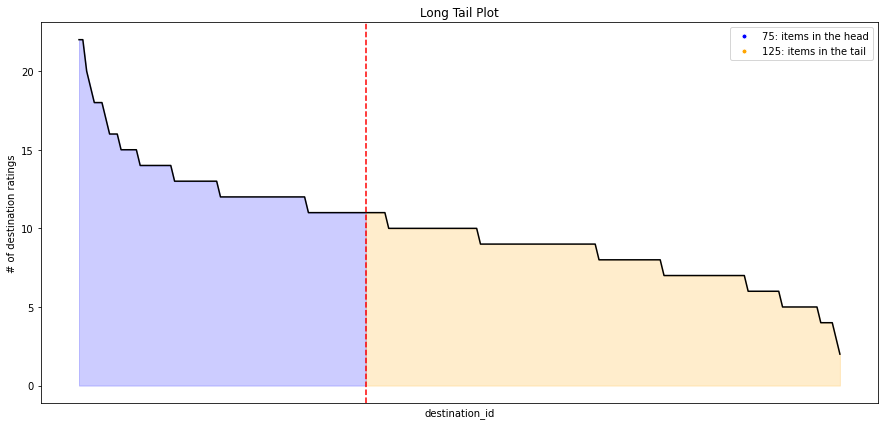

In [15]:
fig = plt.figure(figsize=(15, 7))
recmetrics.long_tail_plot(df=ratings, 
             item_id_column="destination_id", 
             interaction_type="destination ratings", 
             percentage=0.5,
             x_labels=False)

In [16]:
reader = Reader(rating_scale=(0, 5))
data = Dataset.load_from_df(ratings[['user_id', 'destination_id', 'rating']], reader)
trainset, testset = train_test_split(data, test_size=0.25)

In [17]:
test = pd.DataFrame(testset)
test.columns = ['user_id', 'destination_id', 'actual']
test.head()

,user_id,destination_id,actual
0,56,60,5.0
1,6,91,4.0
2,33,198,4.0
3,37,139,4.0
4,0,90,4.0


In [18]:
test = test.copy().groupby('user_id', as_index=False)['destination_id'].agg({'actual': (lambda x: list(set(x)))})
test

,user_id,actual
0,0,"[4, 103, 115, 90, 28, 127]"
1,1,"[184, 130, 51]"
2,2,"[41, 99, 110]"
3,3,"[32, 2, 42, 90, 125, 95]"
4,4,"[9, 43, 182, 153, 123]"
...,...,...
95,95,"[0, 160, 72, 170, 120, 92]"
96,97,"[185, 139, 15, 49, 116, 22, 121]"
97,98,"[137, 106, 70]"
98,99,"[160, 80, 163, 5]"


In [19]:
test = test.set_index("user_id")
test

,actual
user_id,
0,"[4, 103, 115, 90, 28, 127]"
1,"[184, 130, 51]"
2,"[41, 99, 110]"
3,"[32, 2, 42, 90, 125, 95]"
4,"[9, 43, 182, 153, 123]"
...,...
95,"[0, 160, 72, 170, 120, 92]"
97,"[185, 139, 15, 49, 116, 22, 121]"
98,"[137, 106, 70]"


In [32]:
# find the recommended 10 destinations to the users of the test dataset
# and add them to a superlist
super_recommended_ids=[]
for user in test.index:
    most_recent_destination_id=test.loc[user]['actual'][-1] #extract the most recently rated destination id
    recommeneded_ids = model.similar_items(destination_index,N=10)[0].tolist()
    super_recommended_ids.append(recommeneded_ids)
print(super_recommended_ids)

[[1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24], [1, 91, 44, 10, 42, 3, 86, 79, 32, 24],

In [33]:
# update the recommended ids as a new column
test['als_predictions']=super_recommended_ids
test.head()

,actual,als_predictions
user_id,,
0,"[4, 103, 115, 90, 28, 127]","[1, 91, 44, 10, 42, 3, 86, 79, 32, 24]"
1,"[184, 130, 51]","[1, 91, 44, 10, 42, 3, 86, 79, 32, 24]"
2,"[41, 99, 110]","[1, 91, 44, 10, 42, 3, 86, 79, 32, 24]"
3,"[32, 2, 42, 90, 125, 95]","[1, 91, 44, 10, 42, 3, 86, 79, 32, 24]"
4,"[9, 43, 182, 153, 123]","[1, 91, 44, 10, 42, 3, 86, 79, 32, 24]"


In [34]:
actual=test['actual'].values.tolist()
als_predictions=test['als_predictions'].values.tolist()
print(actual)
print(als_predictions)

[[4, 103, 115, 90, 28, 127], [184, 130, 51], [41, 99, 110], [32, 2, 42, 90, 125, 95], [9, 43, 182, 153, 123], [107, 180], [192, 128, 6, 170, 142, 144, 91], [6, 169, 86, 183, 123, 159], [2, 4, 39, 104, 9, 15, 80, 177, 191], [164, 10, 75, 79, 59], [114, 140, 69], [135, 14, 142, 114, 178, 85, 57, 186, 158], [24, 63], [80], [66, 37, 167, 136, 173, 15, 121, 187, 60, 62], [95, 198, 135], [129, 73, 18, 83, 125], [20, 22, 151, 31, 63], [32, 66, 69, 146, 121], [186, 123, 134, 15], [9, 58, 161, 132], [98, 69, 109], [104, 20, 87], [97, 34, 132, 76, 88, 123], [72, 61], [130, 76], [156, 50, 100, 38], [69, 199, 74, 20, 148, 62], [66, 139, 180, 84, 151, 121, 159], [69, 106, 43, 118, 189, 126], [40, 24, 99, 73], [178, 57, 98, 62], [24, 73, 43, 81], [56, 106, 198, 30], [2, 77, 71], [32, 122, 21], [32, 65, 105, 172, 79, 18, 19, 149, 25, 30], [64, 139, 141, 16, 24, 125], [1, 135, 72, 112, 49, 21, 24, 123], [32, 58, 74, 29], [88, 67, 156, 118], [11, 37, 12, 13], [16, 162, 64, 135], [37, 13, 45, 80, 182, 2

In [35]:
# calculate the mark score
als_mark = []
for K in np.arange(1, 11):
    als_mark.extend([recmetrics.mark(actual, als_predictions, k=K)])
als_mark

[0.003611111111111111,
 0.007617063492063492,
 0.009191137566137566,
 0.009918410293410293,
 0.010251743626743626,
 0.010251743626743626,
 0.010966029341029339,
 0.011591029341029341,
 0.013053992303992304,
 0.01472065897065897]

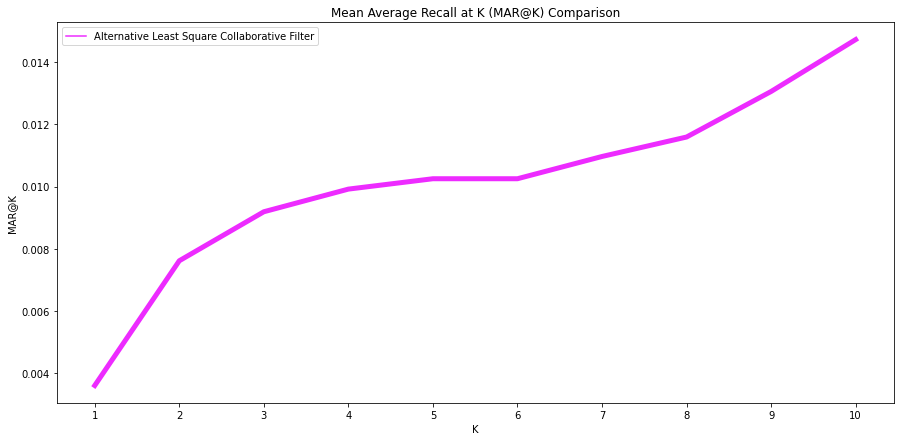

In [36]:
# generate a mark plot
mark_scores = [als_mark]
index = range(1,10+1)
names = ['Alternative Least Square Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mark_plot(mark_scores, model_names=names, k_range=index)

In [37]:
import ml_metrics as metrics

### Similarly, generate MAPK score

In [39]:
als_mapk = []
for K in np.arange(1, 11):
    als_mapk.extend([metrics.mapk(actual, als_predictions, k=K)])
als_mapk

[0.03,
 0.025,
 0.02111111111111111,
 0.0175,
 0.014733333333333331,
 0.012805555555555554,
 0.012326530612244898,
 0.011998511904761906,
 0.013143077601410934,
 0.014743386243386242]

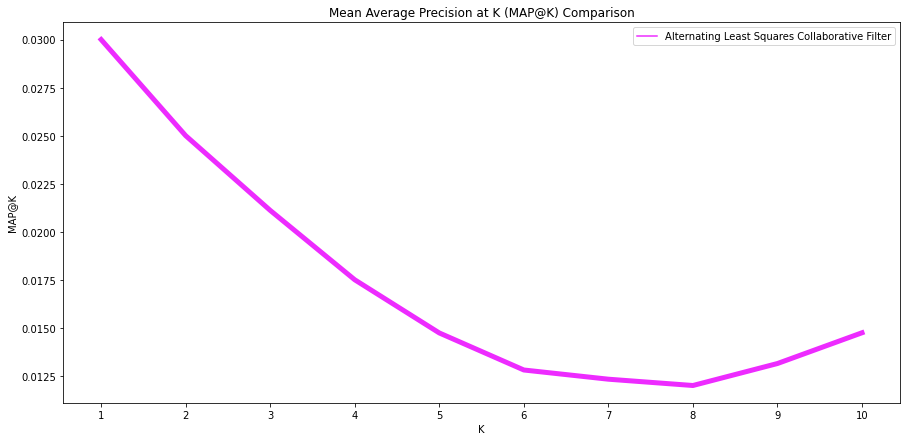

In [40]:
# generate a mapk plot
mapk_scores = [als_mapk]
index = range(1,10+1)
names = ['Alternating Least Squares Collaborative Filter']

fig = plt.figure(figsize=(15, 7))
recmetrics.mapk_plot(mapk_scores, model_names=names, k_range=index)

## Calculate the prediction coverage

In [46]:
catalog = ratings.destination_id.unique().tolist()
als_coverage = recmetrics.prediction_coverage(als_predictions, catalog)
print(als_coverage)

5.0


## Coverage plot

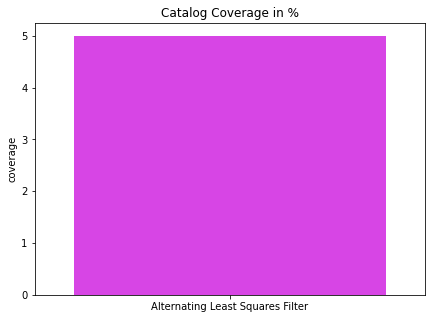

In [43]:
# plot of prediction coverage
als_scores = [als_coverage]
model_names = ['Alternating Least Squares Filter']

fig = plt.figure(figsize=(7, 5))
recmetrics.coverage_plot(als_scores, model_names)

## Intra-list similarity

In [44]:
feature_df=destinations[['history','art_and_architecture','nature','adventure', 'entertainment','health_and_lifestyle',\
                        'food','industries','religious']]
feature_df

,history,art_and_architecture,nature,adventure,entertainment,health_and_lifestyle,food,industries,religious
0,True,True,False,False,False,False,False,False,True
1,False,False,True,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,True,True,False,False,False,False,False,False,True
4,False,False,True,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...
195,True,True,True,False,False,False,False,False,False
196,True,True,True,False,False,False,False,False,False
197,True,True,False,False,False,False,False,False,True
198,False,False,False,False,True,False,False,False,False


In [45]:
recmetrics.intra_list_similarity(als_predictions, feature_df)

0.37007317757736574